# EDA (Inline Only) — Compact & Interpretable

This notebook renders **all** visuals and tables inline in Jupyter. Nothing is exported to disk.

### Outputs
- Class balance (bar chart)
- Top categorical features by outcome-rate variation (bar charts + mini tables)
- Top numeric features (quantile-binned trends) (line charts + mini tables)
- Correlation heatmap (numeric + encoded target)
- High-level summary table

### How to use
1. Set `DATA_PATH` to your cleaned dataset (CSV or HTML table export).
2. Optionally set `TARGET_COL` if auto-detection isn't correct.
3. Run cells top-to-bottom.


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

# ----------------- CONFIG -----------------
DATA_PATH = Path('heart_2025_cleaned.csv') 
TARGET_COL: Optional[str] = None  
MAX_PLOTS_CATEG = 3
MAX_PLOTS_NUM = 3
NUMERIC_BINS = 5

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)


In [2]:
# ----------------- LOAD DATA -----------------
def load_dataset(path: Path) -> pd.DataFrame:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Dataset not found: {p}")
    if p.suffix.lower() in {'.csv'}:
        return pd.read_csv(p)
    if p.suffix.lower() in {'.xlsx', '.xls'}:
        return pd.read_excel(p)
    if p.suffix.lower() in {'.html', '.htm'}:
        tables = pd.read_html(str(p))
        if not tables:
            raise ValueError('No HTML tables found in the file')
        return tables[0]
    raise ValueError('Unsupported file type. Use CSV, Excel, or HTML (table).')

df = load_dataset(DATA_PATH)
print('Loaded shape:', df.shape)
df.head()


Loaded shape: (3069, 17)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,smoking,diabetes,bmi,heart_disease
0,67,Male,2,111,536,0,2,88,0,1.3,3,2,3,1,0,23.4,1
1,57,Male,3,109,107,0,2,119,0,5.4,2,0,3,0,1,35.4,0
2,43,Male,4,171,508,0,1,113,0,3.7,3,0,7,1,1,29.9,0
3,71,Female,4,90,523,0,2,152,0,4.7,2,1,3,1,0,15.2,1
4,36,Male,2,119,131,0,2,128,0,5.9,3,1,3,1,0,16.7,1


## Target detection / encoding

In [3]:
def guess_binary_target(data: pd.DataFrame):
    hints = {'target','outcome','label','y','disease','heart_disease','has_disease','class'}
    for c in data.columns:
        if c.lower() in hints and data[c].dropna().nunique() <= 3:
            return c
    for c in data.columns:
        if data[c].dropna().nunique() <= 3:
            return c
    return None

if TARGET_COL is None:
    TARGET_COL = guess_binary_target(df)
print('TARGET_COL =', TARGET_COL)
assert TARGET_COL is not None, 'Please set TARGET_COL to a binary-like column name.'

# Encode target to 0/1
t = df[TARGET_COL]
if t.dtype == 'object' or str(t.dtype).startswith('category'):
    codes, uniques = pd.factorize(t)
    if len(uniques) == 2:
        y = (codes == codes.max()).astype(int)
    else:
        m = t.astype(str).str.lower().map({'yes':1,'true':1,'1':1,'no':0,'false':0,'0':0})
        if m.dropna().nunique() == 2:
            y = m.fillna(0).astype(int)
        else:
            mode = t.mode().iloc[0]
            y = (t != mode).astype(int)
else:
    if t.dropna().nunique() == 2:
        vals = sorted(t.dropna().unique())
        y = (t == vals[-1]).astype(int)
    else:
        y = (t > t.median()).astype(int)

df['_target_enc'] = y
base_rate = float(df['_target_enc'].mean())
print('Base rate:', round(base_rate, 4))


TARGET_COL = heart_disease
Base rate: 0.3881


## 1) Class balance

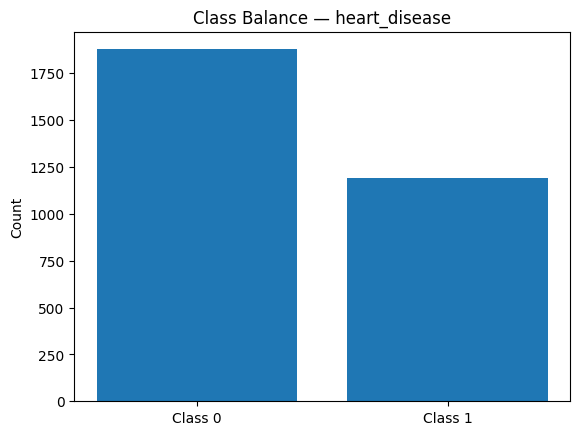

,count
_target_enc,
Class 0,1878
Class 1,1191


In [4]:
counts = df['_target_enc'].value_counts().sort_index()
plt.figure()
plt.bar(['Class 0','Class 1'], counts.values)
plt.title(f'Class Balance — {TARGET_COL}')
plt.ylabel('Count')
plt.show()
display(counts.rename(index={0:'Class 0',1:'Class 1'}).to_frame('count'))


## Helpers: ranking functions

In [5]:
def rate_variation_score_cat(data: pd.DataFrame, col: str, ycol: str) -> float:
    tmp = data[[col, ycol]].dropna()
    if tmp.empty:
        return 0.0
    gp = tmp.groupby(col)[ycol].mean()
    sizes = tmp[col].value_counts().reindex(gp.index)
    w = sizes.values / sizes.values.sum()
    mu = float((gp.values * w).sum())
    var = float(((gp.values - mu)**2 * w).sum())
    return np.sqrt(var)

def rate_variation_score_num(data: pd.DataFrame, col: str, ycol: str, q: int = 5) -> float:
    tmp = data[[col, ycol]].dropna()
    if tmp.empty:
        return 0.0
    try:
        bins = pd.qcut(tmp[col], q=q, duplicates='drop')
    except Exception:
        return 0.0
    gp = tmp.groupby(bins)[ycol].mean()
    sizes = tmp.groupby(bins)[ycol].size().reindex(gp.index)
    w = sizes.values / sizes.values.sum()
    mu = float((gp.values * w).sum())
    var = float(((gp.values - mu)**2 * w).sum())
    return np.sqrt(var)


## 2) Top categorical features (inline charts + mini tables)

In [6]:
cat_cols = [c for c in df.columns if c != '_target_enc' and (df[c].dtype == 'object' or str(df[c].dtype).startswith('category'))]
scores = []
for c in cat_cols:
    if df[c].nunique(dropna=True) > 12:
        continue
    scores.append((c, rate_variation_score_cat(df, c, '_target_enc')))
scores.sort(key=lambda x: x[1], reverse=True)
top_cats = [c for c,_ in scores[:MAX_PLOTS_CATEG]]
top_cats


['sex']

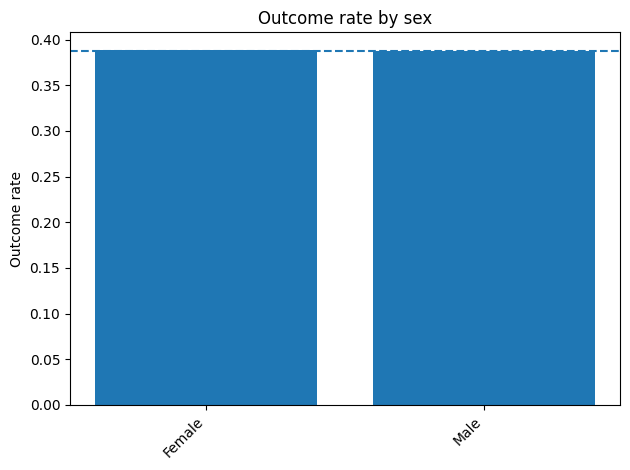

,rate,count
sex,,
Female,0.388563,1364
Male,0.387683,1705


In [7]:
for c in top_cats:
    tmp = df[[c, '_target_enc']].dropna()
    rates = tmp.groupby(c)['_target_enc'].mean().sort_values(ascending=False)
    counts = tmp[c].value_counts().reindex(rates.index)
    # bar chart of rates
    plt.figure()
    plt.bar(rates.index.astype(str), rates.values)
    plt.axhline(y=df['_target_enc'].mean(), linestyle='--')
    plt.title(f'Outcome rate by {c}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Outcome rate')
    plt.tight_layout()
    plt.show()
    # mini table
    display(pd.DataFrame({'rate': rates, 'count': counts}))


## 3) Top numeric features (quantile-binned trends + mini tables)

In [8]:
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in {'_target_enc'}]
scores_num = []
for c in num_cols:
    scores_num.append((c, rate_variation_score_num(df, c, '_target_enc', q=NUMERIC_BINS)))
scores_num.sort(key=lambda x: x[1], reverse=True)
top_nums = [c for c,_ in scores_num[:MAX_PLOTS_NUM]]
top_nums


/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/3713534876.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gp = tmp.groupby(bins)[ycol].mean()
/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/3713534876.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sizes = tmp.groupby(bins)[ycol].size().reindex(gp.index)
/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/3713534876.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

['age', 'oldpeak', 'trestbps']

/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/2959666291.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = tmp.groupby(bins)['_target_enc'].mean()
/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/2959666291.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby(bins)['_target_enc'].size()


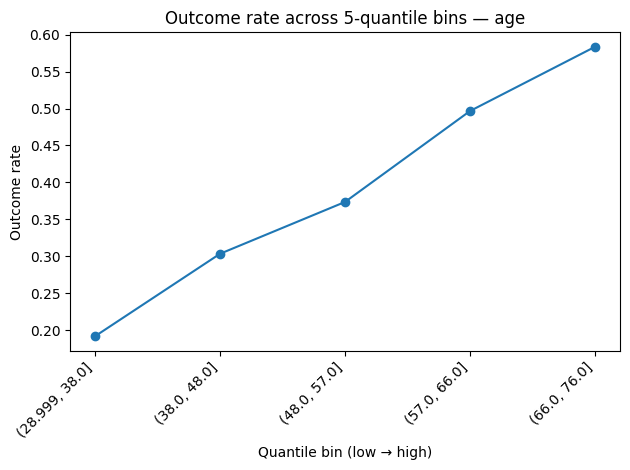

,rate,count
age,,
"(28.999, 38.0]",0.191759,631
"(38.0, 48.0]",0.303426,613
"(48.0, 57.0]",0.373573,613
"(57.0, 66.0]",0.496678,602
"(66.0, 76.0]",0.583607,610


/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/2959666291.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = tmp.groupby(bins)['_target_enc'].mean()
/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/2959666291.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby(bins)['_target_enc'].size()


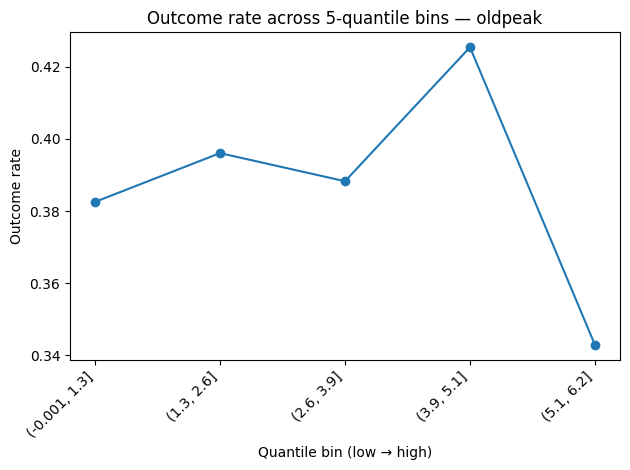

,rate,count
oldpeak,,
"(-0.001, 1.3]",0.382540,630
"(1.3, 2.6]",0.396072,611
"(2.6, 3.9]",0.388273,631
"(3.9, 5.1]",0.425432,637
"(5.1, 6.2]",0.342857,560


/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/2959666291.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = tmp.groupby(bins)['_target_enc'].mean()
/var/folders/p6/90nk3xm55fq2jj2dlpt3bwqr0000gn/T/ipykernel_29428/2959666291.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby(bins)['_target_enc'].size()


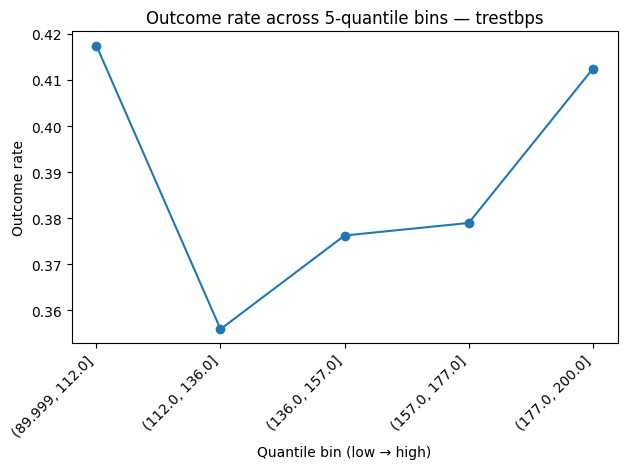

,rate,count
trestbps,,
"(89.999, 112.0]",0.417476,618
"(112.0, 136.0]",0.355906,635
"(136.0, 157.0]",0.376238,606
"(157.0, 177.0]",0.378965,599
"(177.0, 200.0]",0.412439,611


In [9]:
for c in top_nums:
    tmp = df[[c, '_target_enc']].dropna()
    bins = pd.qcut(tmp[c], q=NUMERIC_BINS, duplicates='drop')
    rates = tmp.groupby(bins)['_target_enc'].mean()
    counts = tmp.groupby(bins)['_target_enc'].size()
    # line chart across bins
    x = np.arange(len(rates))
    plt.figure()
    plt.plot(x, rates.values, marker='o')
    plt.title(f'Outcome rate across {NUMERIC_BINS}-quantile bins — {c}')
    plt.xlabel('Quantile bin (low → high)')
    plt.ylabel('Outcome rate')
    plt.xticks(x, [str(b) for b in rates.index], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # mini table
    display(pd.DataFrame({'rate': rates, 'count': counts}))


## 4) Correlation heatmap (numeric + encoded target)

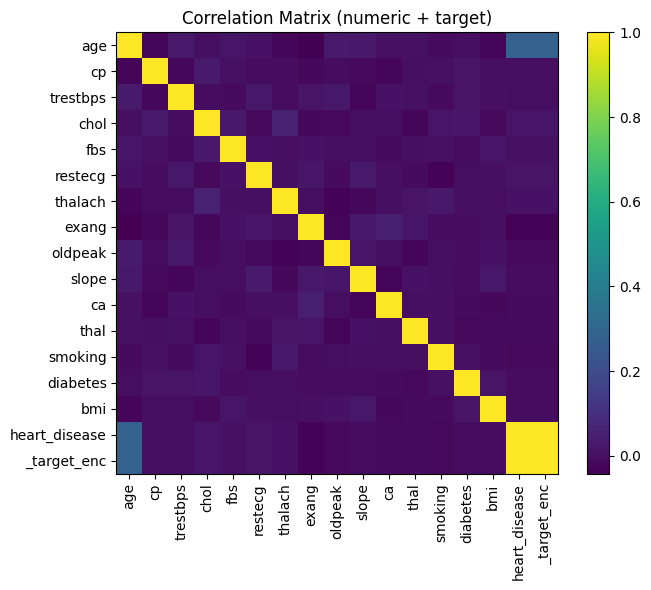

In [10]:
num_for_corr = [c for c in df.select_dtypes(include=[np.number]).columns]
if len(num_for_corr) >= 2:
    corr = df[num_for_corr].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, interpolation='nearest')
    plt.title('Correlation Matrix (numeric + target)')
    plt.xticks(range(len(num_for_corr)), num_for_corr, rotation=90)
    plt.yticks(range(len(num_for_corr)), num_for_corr)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for correlation heatmap')


## High-level summary

In [11]:
hl = pd.DataFrame({
    'metric': ['rows','columns','target','base_rate'],
    'value': [int(df.shape[0]), int(df.shape[1]), TARGET_COL, round(float(df['_target_enc'].mean()), 4)]
})
display(hl)


,metric,value
0,rows,3069
1,columns,18
2,target,heart_disease
3,base_rate,0.3881
